# Galaxy Simulation

## Kreisbahn der Erde um die Sonne 2D

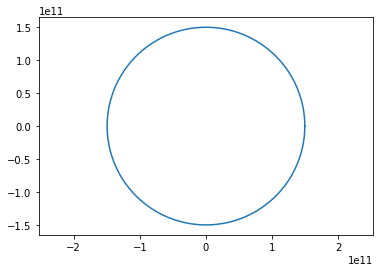

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calc_acceleration(force, mass):
    if mass <= 0:
        raise TypeError('Mass has to be greater than 0')
    return (1/mass)*force

def next_location(mass, position, speed, acceleration, delta_t):
    return (position + delta_t * speed + (delta_t**2/2)*acceleration)

def calc_gravitational_force(mass1, mass2, pos1, pos2):
    delta_pos = np.linalg.norm(pos2-pos1)
    return (6.673*10**-11)*(((mass1*mass2)/delta_pos**3)*(pos2-pos1))

def calc_mass_focus(ignore, masses, positions):
    total_mass = np.sum(masses)
    
    tmp_loc = np.zeros(3, dtype=np.float64)
    
    for i in range(masses.size):
        if i == ignore:
            continue
        tmp_loc = tmp_loc + (masses[i] * positions[i])    
    return (1/(total_mass - masses[i]))*tmp_loc



body_amount = 2
positions = np.zeros((body_amount, 3), dtype=np.float64)
speed = np.zeros((body_amount, 3), dtype=np.float64)
radius = np.zeros((body_amount), dtype=np.float64)
mass = np.zeros((body_amount), dtype=np.float64)

positions[0] = np.array([0,0,0])
speed[0] = [0,0,0]
mass[0] = 1.989*10**30

positions[1] = np.array([1.496*10**11, 0, 0])
speed[1] = np.array([0, 29780, 0])
mass[1] = 5.972*10**24

x_vals = []
y_vals = []

timestep = 100
step_amount = 315400

for i in range(step_amount):
    body = 1
    mass_foc_pos = positions[0]
    mass_foc_weight = mass[0]
    grav_force = calc_gravitational_force(mass[body], mass_foc_weight, positions[body], mass_foc_pos)
    accel = calc_acceleration(grav_force, mass[body])
    speed[body] = speed[body] + accel*timestep
    positions[body] = next_location(mass[body], positions[body], speed[body], accel, timestep)
    x_vals.append(positions[body][0])
    y_vals.append(positions[body][1])

plt.axis('equal')
plt.plot(x_vals, y_vals)

## Testing Cython

In den folgenden Zellen testen wir Cython und wieviel Impact es auf die Laufzeit hat

In [2]:
%load_ext cython

### Version using NumPy Arrays only

In [3]:
from numpy.linalg import norm
from numpy import array

G_CONSTANT = 6.673e-11

def g_force(mass1, mass2, pos1, pos2):
    
    delta_pos = pos2 - pos1
    abs_dpos = norm(delta_pos)
    return G_CONSTANT * (((mass1)/abs_dpos**3)*mass2) * delta_pos

### Cython optimised Version

In [4]:
%%cython -a

cimport cython

import numpy as np
cimport numpy as np
from libc.math cimport sqrt

ctypedef np.float64_t DTYPE_t
cdef float G_CONSTANT_C = 6.673e-11

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[::1] g_force_cython(double mass1, double mass2,
                                 double[::1] pos1, double[::1] pos2):
    
    cdef double[::1] d_pos = subtraction(pos2, pos1)
    cdef double abs_dpos = absolute_vector(d_pos)
    return multiplication(G_CONSTANT_C * ((mass1/abs_dpos**3)*mass2), d_pos)

# SUPPORT METHODS
@cython.boundscheck(False)
cdef double[::1] multiplication(double sca, double[::1] arr):
    cdef np.intp_t i
    for i in range(3):
        arr[i] = sca*arr[i]
    return arr

@cython.boundscheck(False)
cdef double[::1] subtraction(double[::1] arr1, double[::1] arr2):
    cdef np.intp_t i
    for i in range(3):
        arr1[i] = arr1[i] - arr2[i]
    return arr1

@cython.boundscheck(False)
cdef double absolute_vector(double[::1] arr):
    cdef np.intp_t i
    cdef double accumulator = 0.0
    for i in range(3):
        accumulator += arr[i]*arr[i]
    return sqrt(accumulator)

In [5]:
## Initialize masses and positions
import numpy as np

mass1 = 5.972 * 10**24
mass2 = 1.898 * 10**27
pos1 = np.array([108836377761.77997, 70586571455.50005, -1669580584.6400046])
pos2 = np.array([137140635336.02217, -37048853897.46875, 15369312079.6235])

# TIME IT
%timeit g_force(mass1, mass2, pos1, pos2)
%timeit g_force_cython(mass1, mass2, pos1, pos2)

7.92 µs ± 492 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.73 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Cython: *physics_formula*

In [6]:
%load_ext Cython

### calc_acceleration()

In [7]:
def calc_acceleration(force, mass):
    return force/mass

In [8]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython

cpdef double[::1] calc_acceleration_cy(double[::1] force, double mass):
    return multiplication(1/mass, force)


# SUPPORT METHODS
cdef double[::1] multiplication(double sca, double[::1] arr):
    cdef np.intp_t i
    for i in range(3):
        arr[i] = sca*arr[i]
    return arr

In [9]:
sun_weight = 1.989e30
earth_weight = 5.972e24
sun_pos = np.array([0, 0, 0], dtype=np.float64)
earth_pos = np.array([1.496e11, 0, 0], dtype=np.float64)
earth_force = g_force(earth_weight, sun_weight, earth_pos, sun_pos)

# TIME IT
%timeit calc_acceleration(earth_force, earth_weight)
%timeit calc_acceleration_cy(earth_force, earth_weight)

1.25 µs ± 64.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.48 µs ± 55.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### calc_mass_focus()

In [10]:
import numpy as np

def calc_mass_focus(masses, positions):
    tmp_focus = np.zeros(3, dtype=np.float64)
    for i in range(masses.size):
        tmp_focus = tmp_focus + masses[i] * positions[i]
    return tmp_focus/np.sum(masses)

In [11]:
from numba import jit

@jit
def calc_mass_focus_jit(masses, positions):
    tmp_focus = np.zeros(3, dtype=np.float64)
    for i in range(masses.size):
        tmp_focus = tmp_focus + masses[i] * positions[i]
    return tmp_focus/np.sum(masses)

In [12]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel cimport prange

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[::1] calc_mass_focus_cy(double[::1] masses,
                                     double[:, ::1] positions):
    
    cdef double[::1] tmp_foc = np.empty(3, dtype=np.float64)
    cdef double[::1] ret = np.empty(3, dtype=np.float64)
    cdef double total
    cdef np.intp_t i, j
    
    for i in prange(masses.shape[0], nogil=True):
        for j in range(3):
            tmp_foc[j] = tmp_foc[j] + masses[i]*positions[i, j]
        total += masses[i]
    
    for i in prange(3, nogil=True):
        ret[i] = (1/total) * tmp_foc[i]
    return ret

In [13]:
from random import uniform 

N = 5000
positions = np.zeros((N, 3), dtype=np.float64)
mass = np.zeros((N), dtype=np.float64)

for i in range(mass.shape[0]):
    x_pos = uniform(1e10, 1e13)
    y_pos = uniform(1e10, 1e13)
    z_pos = uniform(1e10, 1e13)
    positions[i] = np.array([x_pos,
                             y_pos,
                             z_pos])

    mass[i] = uniform(1e25, 2e30)


# TIME IT
#%timeit calc_mass_focus(mass, positions)
%timeit calc_mass_focus_jit(mass, positions)
%timeit calc_mass_focus_cy(mass, positions)

920 µs ± 270 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.9 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### calc_mass_focus_ignore()

In [14]:
def calc_mass_focus_ignore(ignore, masses, positions):
    
    tmp_loc = np.zeros(3, dtype=np.float64)

    for i in range(masses.size):
        if i == ignore:
            continue
        tmp_loc = tmp_loc + (masses[i] * positions[i])
    return tmp_loc/(np.sum(masses) - masses[ignore])

In [15]:
%%cython -a

# CYTHON USING NDARRAYS

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.float64_t DTYPE_T

@cython.boundscheck(False)
@cython.cdivision(True)
cpdef np.ndarray[DTYPE_T, ndim=1] calc_mass_focus_ignore_cy(np.intp_t ignore,
                                                            np.ndarray[DTYPE_T, ndim=1] masses,
                                                            np.ndarray[DTYPE_T, ndim=2] positions):
    
    cdef np.ndarray[DTYPE_T, ndim=1] tmp_loc = np.empty(3, dtype=np.float64)
    cdef np.intp_t i
    for i in range(masses.shape[0]):
        if i == ignore:
            continue
        tmp_loc = tmp_loc + masses[i] * positions[i]
    return tmp_loc/(np.sum(masses) - masses[ignore])

In [16]:
%%cython -a

# CYTHON USING MEMORYVIEWS

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.wraparound(False)
cpdef double[::1] calc_mass_focus_ignore_memview(np.intp_t ignore,
                                            double[::1] masses,
                                            double[:, ::1] positions):
    
    cdef double[::1] tmp_loc = np.empty(3)
    cdef np.intp_t i
    for i in range(masses.shape[0]):
        if i == ignore:
            continue
        tmp_loc = addition(tmp_loc,multiplication(masses[i], positions[i]))
    return multiplication(1/(total(masses) - masses[ignore]), tmp_loc)


# SUPPORT METHODS
cdef double[::1] multiplication(double sca, double[::1] arr):
    cdef np.intp_t i
    for i in range(3):
        arr[i] = sca*arr[i]
    return arr

cdef double[::1] addition(double[::1] arr1, double[::1] arr2):
    cdef np.intp_t i
    for i in range(3):
        arr1[i] = arr1[i] + arr2[i]
    return arr1

cdef double total(double[::1] arr):
    cdef np.intp_t i
    cdef double tot = 0.0
    for i in range(arr.shape[0]):
        tot += arr[i]
    return tot

In [17]:
from random import uniform 

positions = np.zeros((5000, 3), dtype=np.float64)
mass = np.zeros((5000), dtype=np.float64)
ignore = 255

for i in range(mass.shape[0]):
    x_pos = uniform(1e10, 1e13)
    y_pos = uniform(1e10, 1e13)
    z_pos = uniform(1e10, 1e13)
    positions[i] = np.array([x_pos,
                             y_pos,
                             z_pos])

    mass[i] = uniform(1e25, 2e30)

# TIME IT
%timeit calc_mass_focus_ignore(ignore, mass, positions)
%timeit calc_mass_focus_ignore_cy(ignore, mass, positions)
%timeit calc_mass_focus_ignore_memview(ignore, mass, positions)

12.7 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.11 ms ± 56 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### calc_absolute_speed()

In [18]:
def calc_absolute_speed(body_index, masses, positions):
    
    my_mass, my_position = masses[body_index], positions[body_index]
    mass_focus_ignored = calc_mass_focus_ignore(body_index, masses, positions)
    total_mass = np.sum(masses)

    abs_r = np.linalg.norm(my_position - mass_focus_ignored)
    print(abs_r)
    return ((total_mass - my_mass) /
            total_mass)*np.sqrt(G_CONSTANT*total_mass/abs_r)

In [19]:
%%cython
cimport cython
from libc.math cimport sqrt
import numpy as np
cimport numpy as np

ctypedef np.float64_t DTYPE_T

cdef float G_CONSTANT = 6.673e-11

@cython.wraparound(False)
cpdef double calc_absolute_speed_cy(int body_index, double[::1] masses, double[:, ::1] positions):
    
    cdef double my_mass = masses[body_index]
    cdef double[::1] my_pos = positions[body_index]
    cdef double total_mass = total(masses)
    
    cdef double[::1] to_norm = subtraction(my_pos, calc_mass_focus_ignore_memview(body_index, masses, positions))
    cdef double abs_r = absolute_vector(to_norm)
    print(abs_r)
    return ((total_mass - my_mass) / total_mass) * sqrt(G_CONSTANT * total_mass/abs_r)
    

# SUPPORT METHODS
@cython.boundscheck(False)
cdef double[::1] multiplication(double sca, double[::1] arr):
    cdef np.intp_t i
    for i in range(3):
        arr[i] = sca*arr[i]
    return arr

@cython.boundscheck(False)
cdef double[::1] addition(double[::1] arr1, double[::1] arr2):
    cdef np.intp_t i
    for i in range(3):
        arr1[i] = arr1[i] + arr2[i]
    return arr1

@cython.boundscheck(False)
cdef double[::1] subtraction(double[::1] arr1, double[::1] arr2):
    cdef np.intp_t i
    for i in range(3):
        arr1[i] = arr1[i] - arr2[i]
    return arr1

@cython.boundscheck(False)
cdef double absolute_vector(double[::1] arr):
    cdef np.intp_t i
    cdef double accumulator = 0.0
    for i in range(3):
        accumulator += arr[i]*arr[i]
    return sqrt(accumulator)

@cython.boundscheck(False)
cdef double total(double[::1] arr):
    cdef np.intp_t i
    cdef double tot = 0.0
    for i in range(arr.shape[0]):
        tot += arr[i]
    return tot

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double[::1] calc_mass_focus_ignore_memview(np.intp_t ignore,
                                            double[::1] masses,
                                            double[:, ::1] positions):
    
    cdef double[::1] tmp_loc = np.empty(3)
    cdef np.intp_t i
    for i in range(masses.shape[0]):
        if i == ignore:
            continue
        tmp_loc = addition(tmp_loc,multiplication(masses[i], positions[i]))
    return multiplication(1/(total(masses) - masses[ignore]), tmp_loc)

In [20]:
from random import uniform 

positions = np.zeros((5000, 3), dtype=np.float64)
mass = np.zeros((5000), dtype=np.float64)
ignore = 255

for i in range(mass.shape[0]):
    x_pos = uniform(1e10, 1e13)
    y_pos = uniform(1e10, 1e13)
    z_pos = uniform(1e10, 1e13)
    positions[i] = np.array([x_pos,
                             y_pos,
                             z_pos])

    mass[i] = uniform(1e25, 2e30)

# TIME IT
%timeit calc_absolute_speed(ignore, mass, positions)
%timeit calc_absolute_speed_cy(ignore, mass, positions)

3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
3684944585453.1226
368494458545

### move circle tests

In [21]:
import numpy as np
from numba import jit
import physics_formula as pf
import simulation_constants as sc

__FPS = 60
__DELTA_ALPHA = 0.01


#@jit
def move_bodies_circle(positions, speed, mass, timestep):
    for i in range(1, mass.size):

        # MASS FOCUS POSITION
        tmp_loc = np.zeros(3, dtype=np.float64)
        for j in range(mass.size):
            if j == i:
                continue
            tmp_loc = tmp_loc + (mass[j] * positions[j])
        mass_foc_pos = tmp_loc/(np.sum(mass) - mass[i])
        mass_foc_weight = np.sum(mass) - mass[i]

        # G FORCE
        delta_pos = mass_foc_pos - positions[i]
        absolute_dpos = np.linalg.norm(delta_pos)
        accel= sc.G_CONSTANT * ((mass_foc_weight)/absolute_dpos**3) * (delta_pos)

        # NEXT LOCATION
        positions[i] = positions[i] + timestep * speed[i] + (timestep**2/2)*accel
        
        speed[i] = speed[i] + timestep * accel

In [36]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

__FPS = 60
__DELTA_ALPHA = 0.01
cdef double G_CONSTANT = 6.673e-11


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef void move_bodies_circle_cy(double[:, ::1] positions,
                                 double[:, ::1] speed,
                                 double[::1] mass,
                                 double timestep):

    cdef np.intp_t i, j, c
    cdef double[::1] tmp_loc = np.empty(3, dtype=np.float64)
    cdef double[::1] mass_foc_pos = np.empty(3, dtype=np.float64)
    cdef double[::1] delta_pos = np.empty(3, dtype=np.float64)
    cdef double[::1] grav_force = np.empty(3, dtype=np.float64)
    cdef double[::1] accel = np.empty(3, dtype=np.float64)
    
    cdef double mass_foc_weight
    cdef double accumulator = 0.0
    cdef double abs_delta_pos

    for i in range(1, mass.shape[0]):
        # MASS FOCUS POSITION
        mass_foc_weight = 0.0
        tmp_loc = np.empty(3, dtype=np.float64) # maybe np.zeros?
        for j in range(mass.shape[0]):
            if j == i:
                continue
            mass_foc_weight += mass[j]

            tmp_loc[0] = tmp_loc[0] + mass[j] * positions[j][0]
            tmp_loc[1] = tmp_loc[1] + mass[j] * positions[j][1]
            tmp_loc[2] = tmp_loc[2] + mass[j] * positions[j][2]

        accumulator = 0.0
        for j in range(3):
            tmp_loc[j] = tmp_loc[j]/mass_foc_weight

            delta_pos[j] = tmp_loc[j] - positions[i, j]

            accumulator += delta_pos[j]*delta_pos[j]

        abs_delta_pos = sqrt(accumulator)

        for j in range(3):
            # G FORCE TO ACCELERATION
            accel[j] = G_CONSTANT * (mass_foc_weight/(abs_delta_pos*abs_delta_pos*abs_delta_pos)) * delta_pos[j]
            # NEXT LOCATION
            positions[i][j] = positions[i][j] + timestep * speed[i][j] + (timestep*timestep/2.0) * accel[j]
            # SPEED
            speed[i][j] = speed[i][j] + timestep * accel[j]

In [50]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
import physics_formula as pf
from random import random, uniform
from libc.stdlib cimport rand, RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef int _get_sign():
    return 1 if rand()/RAND_MAX >= 0.5 else -1

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def _initialise_bodies(int nr_of_bodies):
    min_mass = 1e16
    max_mass = 1e24
    min_radius = 1e9
    max_radius = 4e9
    min_distance = 1e10
    max_distance = 1.496e11
    max_z = 4e10

    black_hole_weight = 2e29

    cdef double[:, ::1] positions = np.zeros((nr_of_bodies+1, 3), dtype=np.float64)
    cdef double[:, ::1] speed = np.zeros((nr_of_bodies+1, 3), dtype=np.float64)
    
    cdef double[::1] radius = np.zeros((nr_of_bodies+1), dtype=np.float64)
    cdef double[::1] mass = np.zeros((nr_of_bodies+1), dtype=np.float64)
    
    cdef double[::1] tmp_speed = np.zeros((nr_of_bodies+1), dtype=np.float64)

    # Black Hole
    positions[0][0] = 0
    positions[0][1] = 0
    positions[0][2] = 0
    speed[0][0] = 0
    speed[0][1] = 0
    speed[0][2] = 0
    mass[0] = black_hole_weight
    radius[0] = 5000000000
    
    cdef int i, j

    for i in range(1, nr_of_bodies+1):
        x_pos = (min_distance + rand()/(RAND_MAX*max_distance))*_get_sign()
        
        y_pos = (min_distance + rand()/(RAND_MAX*sqrt(max_distance**2 - x_pos**2)))*_get_sign()
        z_pos = (min_distance + rand()/RAND_MAX*max_z)*_get_sign()
        # Note: y_pos gets randomly generated between the min distance and
        #       the distance so that the length of the (x, y) vector
        #       is never longer than max_distance.

        positions[i][0] = x_pos
        positions[i][1] = y_pos
        positions[i][2] = z_pos

        mass[i] = min_mass + rand()/RAND_MAX*max_mass
        radius[i] = min_radius + rand()/RAND_MAX*max_radius

    
    for i in range(1, nr_of_bodies+1):
        tmp_speed = pf.calc_speed_direction(i, mass, positions)
        speed[i][0] = tmp_speed[0]
        speed[i][1] = tmp_speed[1]
        speed[i][2] = tmp_speed[2]

    return positions, speed, radius, mass

In [51]:
positions, speed, radius, mass = _initialise_bodies(40)


N = 1000

for i in range(N):
    move_bodies_circle_cy(cy_positions, cy_speed, mass, 2500.0)

print('\n\n')

for i in range(cy_positions.shape[0]):
    print("\nCY POS: ", end = ' ')
    for j in range(cy_positions.shape[1]):
        print(cy_positions[i, j], end=' ')
        
for i in range(cy_speed.shape[0]):
    print("\nCY SPEED: ", end=' ')
    for j in range(cy_speed.shape[1]):
        print(cy_speed[i, j], end=' ')
    
print('\n\n')

for i in range(N):
    move_bodies_circle(positions, speed, mass, 2500.0)

print("POSITIONS: ")
print(positions)
print("SPEED: ")
print(speed)

ValueError: too many values to unpack (expected 4)